#**Basic regression: Predict fuel efficiency**
* This notebook uses the classic Auto MPG Dataset and builds a model to predict the fuel efficiency of late-1970s and early 1980s automobiles. 
* To do this, we'll provide the model with a description of many automobiles from that time period. 
* This description includes attributes like: cylinders, displacement, horsepower, and weight.

In [1]:
!pip install -q seaborn # for pairplot
!pip install -q git+https://github.com/tensorflow/docs # some function tensorflow_docs

In [2]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

print(tf.__version__)
if tf.__version__ != '2.0.0':
  !pip install tensorflow==2.0.0
  print("** Tensorflow updated **")

2.0.0


#**The Auto MPG dataset**
The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).

In [3]:
datasetPath = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
datasetPath

'/root/.keras/datasets/auto-mpg.data'

Import it using pandas

In [0]:
columnNames = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']

rawDataset = pd.read_csv(datasetPath, names=columnNames,
                         na_values='?', comment='\t',
                         sep=' ', skipinitialspace=True) #seperator

In [5]:
dataset = rawDataset.copy()
dataset.tail() #[25:35]

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


#**Clean the data**

In [6]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [0]:
dataset = dataset.dropna() # del the raws

**The "Origin" column is really categorical, not numeric. So convert that to a one-hot**

In [8]:
dataset['Origin'] = dataset['Origin'].map(lambda x:{1:'Usa', 2:'Europe', 3:'Japan'}.get(x))
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()#[25:35]

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,Usa
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


#**Split the data into train and test**
Now split the dataset into a training set and a test set.

In [0]:
trainDataset = dataset.sample(frac=0.8, random_state=0)
testDataset = dataset.drop(trainDataset.index)


Let's look at the data distribution quickly

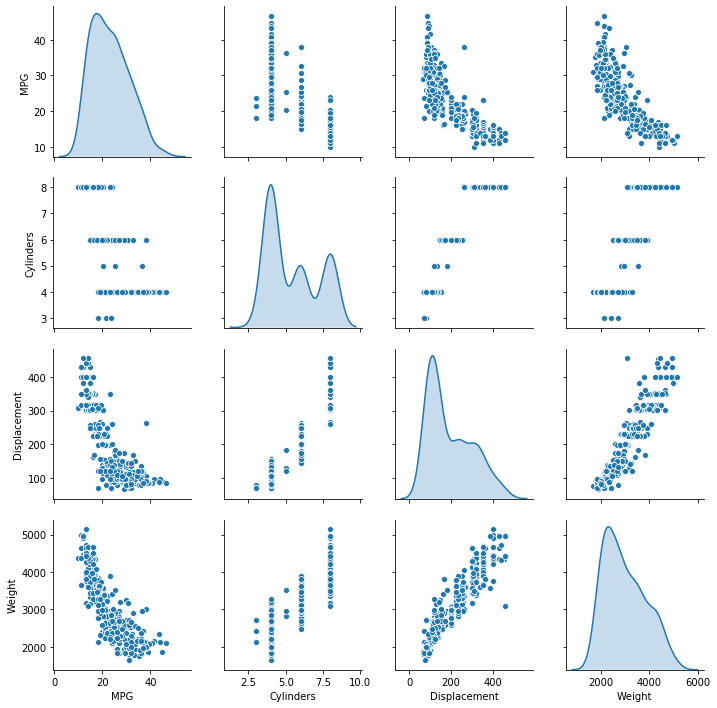

In [10]:
sns.pairplot(trainDataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind='kde')

####**General statistics in data**

In [11]:
trainStats = trainDataset.describe()
trainStats.pop("MPG")
trainStats = trainStats.transpose()
trainStats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
Usa,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


#**Split features from labels**
* Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.
* This tag is the value we will train to estimate the model.

In [0]:
trainLabels = trainDataset.pop("MPG")
testLabels = testDataset.pop("MPG")

#**Normalize the data**
* Look again at the train_stats block above and note how different the ranges of each feature are.

* **Outlier** is a data point that differs significantly from other observations.

> * Lower Outlier = Q1 – (1.5 * IQR)
* Higher Outlier= Q3 + (1.5 * IQR)

![alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQX51DPhHlit_a9OSwyvB-YPj1gv8hsGsHZSOGVE-_emMeTBqgq)




In [0]:
def norm(x):
  return (x - trainStats['mean']) / trainStats['std']
normedTrainData = norm(trainDataset)
normedTestData = norm(testDataset)

In [14]:
normedTrainData

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,Usa
146,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397,-0.465148,-0.495225,0.774676
282,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910,-0.465148,-0.495225,0.774676
69,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519,-0.465148,-0.495225,0.774676
378,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094,-0.465148,-0.495225,0.774676
331,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971,-0.465148,2.012852,-1.286751
...,...,...,...,...,...,...,...,...,...
281,0.307270,0.044872,-0.521559,-0.000298,0.946772,0.843910,-0.465148,-0.495225,0.774676
229,1.483887,1.961837,1.972127,1.457223,-1.598734,0.299787,-0.465148,-0.495225,0.774676
150,-0.869348,-0.836932,-0.311564,-0.710099,-0.021237,-0.516397,-0.465148,2.012852,-1.286751
145,-0.869348,-1.076553,-1.151543,-1.169870,1.233589,-0.516397,-0.465148,2.012852,-1.286751


**This normalized data is what we will use to train the model.**

#**Build the model**
* Here, we'll use a Sequential model with two densely connected hidden layers, and an output layer that returns a single, continuous value. 
* The model building steps are wrapped in a function, build_model, since we'll create a second model, later on.

In [0]:
def buildModel():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(trainDataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)])
  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [0]:
model = buildModel()

Let's use the **'.summary'** method to print a simple description of the model.

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


Now let's try the model. Let's take 10 examples of training data and call **'model.predict'**

In [18]:
exampleBatch = normedTrainData[:10]
exampleResult = model.predict(exampleBatch)
exampleResult

array([[ 0.20418037],
       [-0.18000203],
       [ 0.22825687],
       [-0.11123344],
       [-0.21182889],
       [-0.13698897],
       [-0.21685006],
       [-0.4370276 ],
       [ 0.02112506],
       [ 0.0534494 ]], dtype=float32)

It seems to be working :) and gives a result of the expected shape and type.

#**Train The Model**
* Train the model for 1000 epochs and record the training and validation accuracy in the history object.

In [19]:
EPOCHS = 1000
history = model.fit(normedTrainData, trainLabels,
                    epochs=EPOCHS, validation_split=0.2,
                    verbose=0, callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:565.4755,  mae:22.5032,  mse:565.4755,  val_loss:553.1366,  val_mae:22.2365,  val_mse:553.1367,  
....................................................................................................
Epoch: 100, loss:6.2175,  mae:1.7367,  mse:6.2175,  val_loss:8.5687,  val_mae:2.1656,  val_mse:8.5687,  
....................................................................................................
Epoch: 200, loss:5.2659,  mae:1.5893,  mse:5.2659,  val_loss:8.1248,  val_mae:2.2101,  val_mse:8.1248,  
....................................................................................................
Epoch: 300, loss:4.7842,  mae:1.4392,  mse:4.7842,  val_loss:8.0897,  val_mae:2.1707,  val_mse:8.0897,  
....................................................................................................
Epoch: 400, loss:4.3294,  mae:1.3806,  mse:4.3294,  val_loss:7.8898,  val_mae:2.1544,  val_mse:7.8898,  
..............................................................

#**Now, using the statistics stored in the history object, let's visualize the model's educational progress.**

In [20]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.370739,0.999838,2.370739,8.770877,2.320844,8.770878,995
996,2.614016,1.045870,2.614016,8.473002,2.247460,8.473002,996
997,2.288280,0.954318,2.288280,7.970179,2.211668,7.970179,997
998,2.564508,1.020403,2.564508,8.027097,2.201139,8.027097,998
999,2.293963,0.989173,2.293963,8.977672,2.321130,8.977672,999


In [0]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [MPG]')

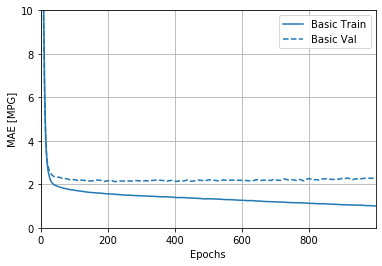

In [22]:
plotter.plot({'Basic' : history}, metric="mae")
plt.ylim([0,10])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

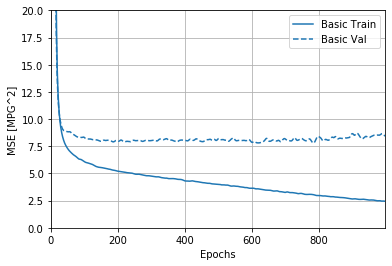

In [23]:
plotter .plot({'Basic' : history}, metric='mse')
plt.ylim([0,20])
plt.ylabel('MSE [MPG^2]')

This graph shows little improvement, or even degradation in the validation error after about 100 epochs. Let's update the model.fit call to automatically stop training when the validation score doesn't improve. We'll use an EarlyStopping callback that tests a training condition for every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

In [24]:
model = buildModel()
# The patience parameter is the amount of epochs to check for improvement

earlyStop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

earlyHistory = model.fit(normedTrainData, trainLabels,
                         epochs=EPOCHS, validation_split=0.2,
                         verbose=0, callbacks=[earlyStop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:560.8211,  mae:22.3243,  mse:560.8211,  val_loss:547.3196,  val_mae:21.9614,  val_mse:547.3196,  
.................................................

Text(0, 0.5, 'MAE [MPG]')

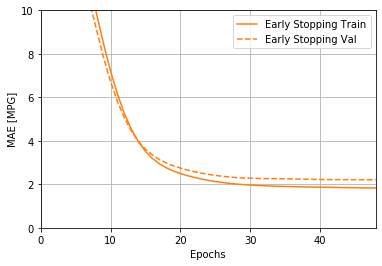

In [25]:
plotter.plot({'Early Stopping' : earlyHistory}, metric='mae')
plt.ylim([0,10])
plt.ylabel('MAE [MPG]')

* The graph shows that on the validation set, the average error is usually around +/- 2 MPG. Is this good? 
* Let's see how well the model generalizes by using the test set, which we did not use when training the model. This tells us how well we can expect the model to predict when we use it in the real world.

In [26]:
loss, mae, mse = model.evaluate(normedTestData, testLabels, verbose=2)
print("Testing set mean abs error : {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 6.1318 - mae: 1.8875 - mse: 6.1318
Testing set mean abs error :  1.89 MPG


#**Make predictions**
Finally, predict MPG values using data in the testing set:

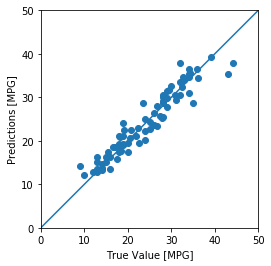

In [27]:
testPredictions = model.predict(normedTestData).flatten()
a = plt.axes(aspect='equal')
plt.scatter(testLabels, testPredictions)
plt.xlabel('True Value [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0,50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

##**It looks like our model predicts reasonably well. Let's take a look at the error distribution.**

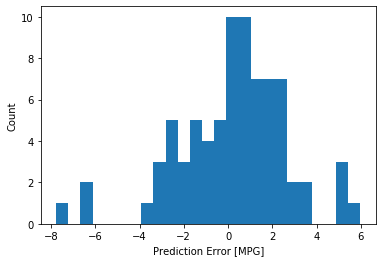

In [28]:
error = testPredictions - testLabels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

#**In Summary**
* Mean Squared Error (MSE) is a common loss function used for regression problems (different loss functions are used for classification problems).
* Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
* When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
* If there is not much training data, one technique is to prefer a small network with few hidden layers to avoid overfitting.
* Early stopping is a useful technique to prevent overfitting.